<a href="https://colab.research.google.com/github/sauralph/MetodosPredictivosII/blob/main/Synthetic%20Data%20and%20Validation/Backtesting_On_Synthetic_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisitos y Dependencias

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Cargar Datos Historicos

In [2]:
# Step 1: Get Bitcoin historical data from Yahoo Finance
btc_data = yf.download("BTC-USD", start="2020-01-01", end=pd.Timestamp.today().strftime('%Y-%m-%d'))
prices = btc_data['Close']

# Interpolate NA values
prices = prices.interpolate()

# Difference the series
prices = prices.diff().dropna()

prices

[*********************100%%**********************]  1 of 1 completed


Date
2020-01-02    -214.704102
2020-01-03     359.414062
2020-01-04      65.772461
2020-01-05       0.660645
2020-01-06     357.901855
                 ...     
2024-07-12     554.550781
2024-07-13    1332.488281
2024-07-14    1555.839844
2024-07-15    4082.359375
2024-07-16     226.996094
Name: Close, Length: 1658, dtype: float64

# Definir Funciones

In [3]:

# Step 1: Estimate input parameters {sigma, phi}
def estimate_parameters(prices, E0):
    T_max = len(prices)
    X = []
    Y = []

    for t in range(T_max - 1):
        X.append(prices[t] - E0)
        Y.append(prices[t + 1])

    X = np.array(X).reshape(-1, 1)
    Y = np.array(Y).reshape(-1, 1)

    model = LinearRegression().fit(X, Y)
    phi_hat = model.coef_[0][0]

    Z = np.full((T_max - 1, 1), E0)
    residuals = Y - Z - phi_hat * X
    sigma_hat = np.sqrt(np.var(residuals))

    return sigma_hat, phi_hat

# Step 2: Construct mesh of stop-loss and profit-taking pairs
def construct_mesh(sigma):
    pi = np.linspace(-12 * sigma, -sigma, 10)
    pi_bar = np.linspace(sigma, 12 * sigma, 10)
    mesh = np.array(np.meshgrid(pi, pi_bar)).T.reshape(-1, 2)
    return mesh

# Step 3: Generate paths
def generate_paths(N, T_max, sigma, phi, initial_price, E0):
    paths = np.zeros((N, T_max))
    paths[:, 0] = initial_price
    for i in range(N):
        for t in range(1, T_max):
            paths[i, t] = E0 + phi * (paths[i, t - 1] - E0) + np.random.normal(0, sigma)
    return paths

# Step 4: Apply stop-loss and profit-taking logic
def apply_trading_logic(paths, mesh, T_max):
    N = paths.shape[0]
    results = []

    for pi, pi_bar in mesh:
        final_pnl = []

        for j in range(N):
            for t in range(T_max):
                pnl = paths[j, t] - paths[j, 0]
                if pnl <= pi or pnl >= pi_bar:
                    final_pnl.append(pnl)
                    break
                if t == T_max - 1:
                    final_pnl.append(pnl)

        sharpe_ratio = np.mean(final_pnl) / np.std(final_pnl)
        results.append([pi, pi_bar, sharpe_ratio])

    return pd.DataFrame(results, columns=['pi', 'pi_bar', 'sharpe_ratio'])

# Step 5: Determine optimal trading rule
def determine_optimal_rule(results):
    return results.loc[results['sharpe_ratio'].idxmax()]


# Correr Simulaciones

In [4]:
# Example usage
# Define input data
_E0 = prices.mean()

# Step 1: Estimate parameters
sigma_hat, phi_hat = estimate_parameters(prices.values, _E0)

# Step 2: Construct mesh
mesh = construct_mesh(sigma_hat)

# Step 3: Generate paths
N = 100000
T_max = 100
initial_price = prices.iloc[0]
paths = generate_paths(N, T_max, sigma_hat, phi_hat, initial_price, _E0)

# Step 4: Apply trading logic
results = apply_trading_logic(paths, mesh, T_max)

# Step 5: Determine optimal rule
optimal_rule = determine_optimal_rule(results)


print(optimal_rule)

pi             -14778.047642
pi_bar           1231.503970
sharpe_ratio        3.303940
Name: 0, dtype: float64


# Explorar espacio de Estrategias

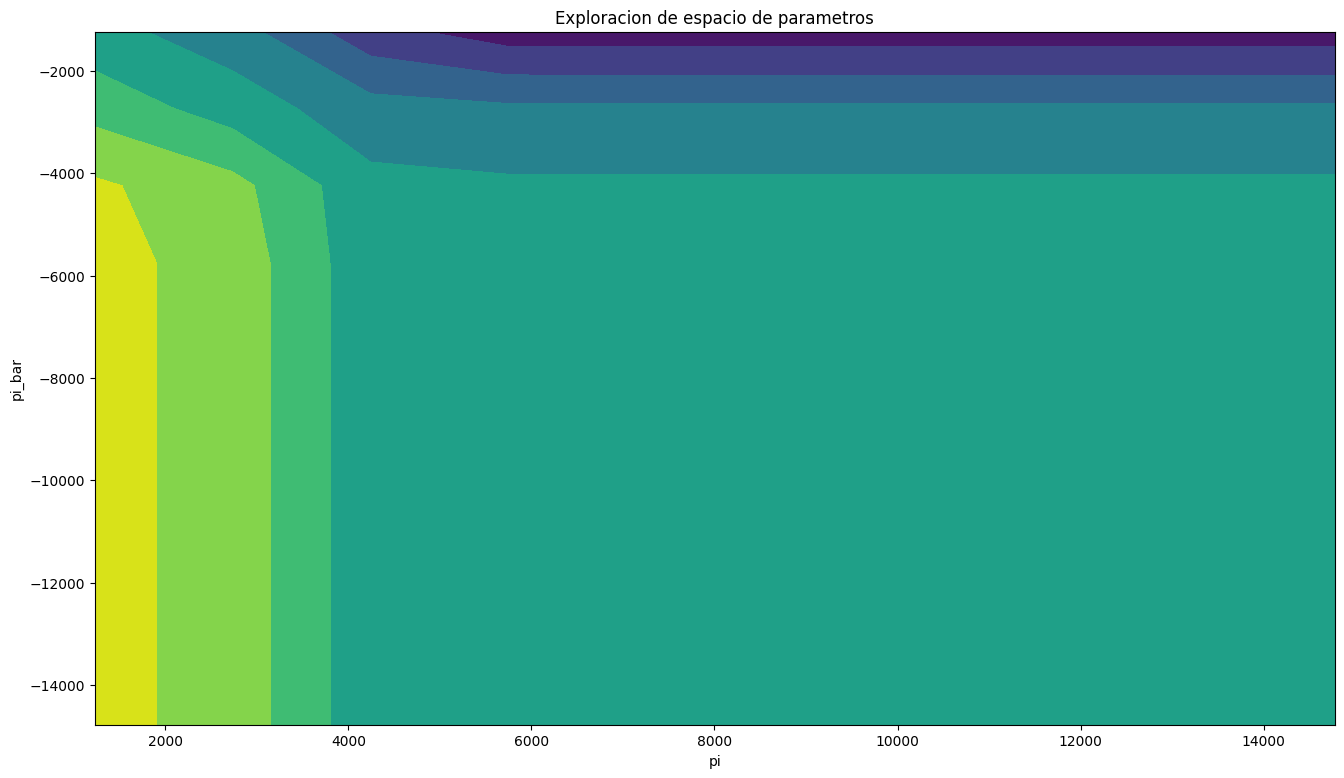

In [6]:
# Plot the contour
sorted_results = results.sort_values(by=['pi', 'pi_bar'])
pivot_table = sorted_results.pivot_table('sharpe_ratio','pi', 'pi_bar')
plt.figure(figsize=(16, 9))
contour = plt.contourf(pivot_table.columns, pivot_table.index, pivot_table, cmap='viridis')
plt.title('Exploracion de espacio de parametros')
plt.xlabel('pi')
plt.ylabel('pi_bar')
plt.show()

# Aplicar Estrategia a datos historicos

In [7]:
# Testing the strategy on Bitcoin data
def apply_strategy(prices, pi, pi_bar):
    initial_price = prices.iloc[0]
    pnl = 0
    for t in range(1, len(prices)):
        current_price = prices.iloc[t]
        pnl = current_price - initial_price

        if pnl <= pi or pnl >= pi_bar:
            break
    return pnl

# Define function to test strategy on historical data
def test_strategy(prices, pi, pi_bar):
    pnl_list = []
    return_list = []
    for start in range(len(prices) - 1):
        pnl = apply_strategy(prices[start:], pi, pi_bar)
        pnl_list.append(pnl)
        return_list.append(pnl/prices.iloc[start])

    sharpe_ratio = np.mean(pnl_list) / np.std(pnl_list)
    return pnl_list, sharpe_ratio, return_list

pi = optimal_rule['pi']
pi_bar = optimal_rule['pi_bar']

pnl_list, sharpe_ratio,return_list = test_strategy(prices, pi, pi_bar)

# Distribucion de los PnL para la estrategia Optima

1988.1632188372246 1197.2859383561367 1.6605583972421454
-8.125497583579987 281.2947216429732 1.6605583972421454


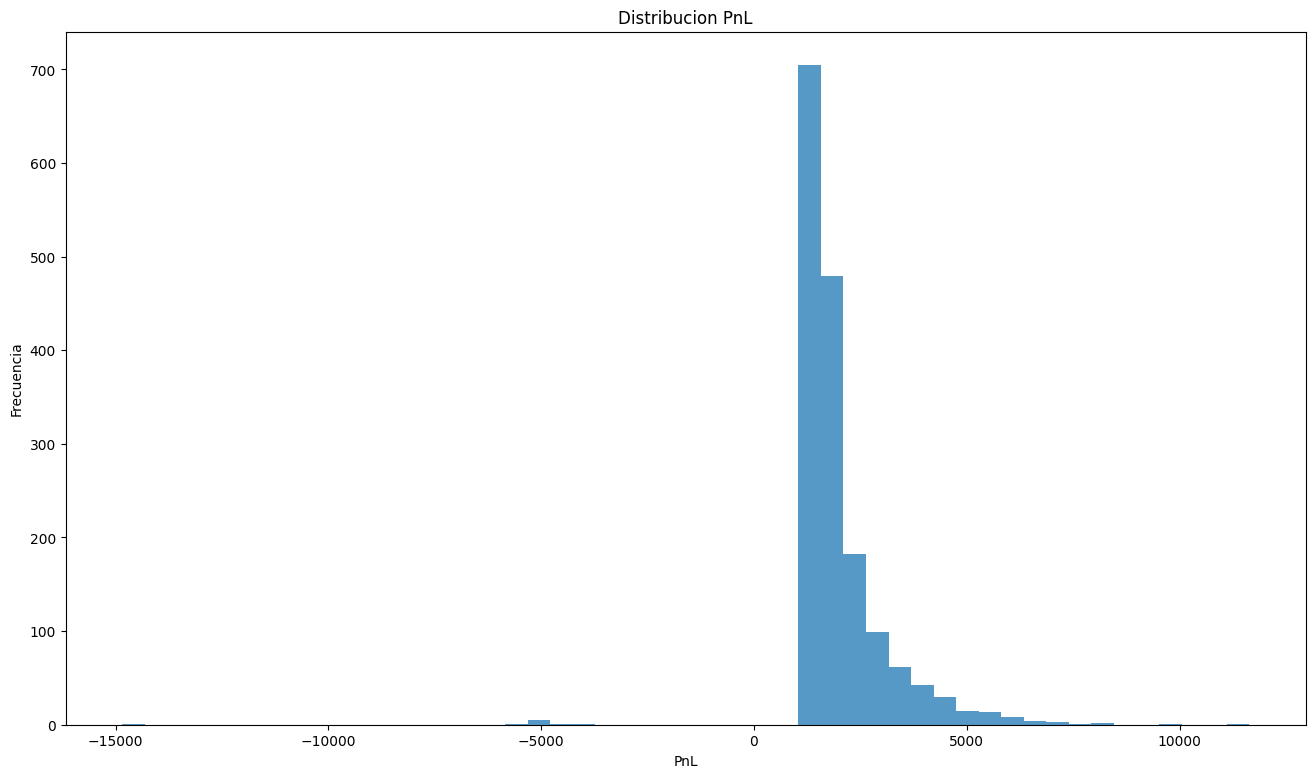

In [9]:
print(np.mean(pnl_list), np.std(pnl_list), sharpe_ratio)
print(np.mean(return_list), np.std(return_list), sharpe_ratio)
plt.figure(figsize=(16,9))
plt.hist(pnl_list, bins=50, alpha=0.75)
plt.title('Distribucion PnL')
plt.xlabel('PnL')
plt.ylabel('Frecuencia')
plt.show()

# Importar Librerias

In [10]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Definir Parametros

In [12]:
# Set parameters
S0 = 100      # Initial stock price
K = 105       # Strike price
T = 1         # Time to maturity in years
r = 0.05      # Risk-free interest rate
sigma = 0.2   # Volatility of the stock
M = 100       # Number of time steps
N = 10000     # Number of simulation paths

# Simular Stock Mediante GBM

In [13]:

# Simulate stock price paths
np.random.seed(123)
dt = T / M
S = np.zeros((N, M+1))
S[:, 0] = S0

for i in range(1, M+1):
    Z = np.random.randn(N)
    S[:, i] = S[:, i-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

# Calculate 95% confidence intervals
S_mean = np.mean(S, axis=0)
S_ci_upper = np.quantile(S, 0.975, axis=0)
S_ci_lower = np.quantile(S, 0.025, axis=0)

print(S_mean)
print(S_ci_upper)
print(S_ci_lower)

[100.         100.06937304 100.14053232 100.18864996 100.26190466
 100.31175425 100.35174296 100.40423464 100.4563473  100.51343822
 100.52970405 100.55114421 100.61293531 100.6528192  100.72299733
 100.79448609 100.8767335  100.93751404 100.98628842 101.06655731
 101.12204251 101.17156424 101.22981956 101.31872919 101.33888018
 101.40411918 101.43547614 101.47066326 101.53811705 101.60526249
 101.62966125 101.67177097 101.72387036 101.7837776  101.86123257
 101.8998804  101.96542892 102.0053356  102.05057665 102.08620764
 102.14641114 102.17821398 102.22495063 102.22741606 102.3109742
 102.37313259 102.42886756 102.4787281  102.52150676 102.57979296
 102.62103219 102.65686877 102.71496324 102.77335462 102.81837658
 102.89162861 102.92635683 102.96772229 103.0195405  103.05643044
 103.1169441  103.16563983 103.1772477  103.26198108 103.29637812
 103.32697807 103.35080671 103.36138015 103.41030488 103.45314118
 103.52627221 103.575171   103.60917496 103.67650975 103.73877184
 103.818982

# Calculos de Pricing the opciones

In [14]:
# Monte Carlo option pricing
payoffs = np.maximum(S[:, -1] - K, 0)
discounted_payoffs = np.exp(-r * T) * payoffs
mc_option_price = np.mean(discounted_payoffs)

# Black-Scholes option pricing
d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
bs_option_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Print option prices
print(f"Monte Carlo Option Price: {mc_option_price:.2f}")
print(f"Black-Scholes Option Price: {bs_option_price:.2f}")

Monte Carlo Option Price: 7.99
Black-Scholes Option Price: 8.02


# Simulaciones GBM

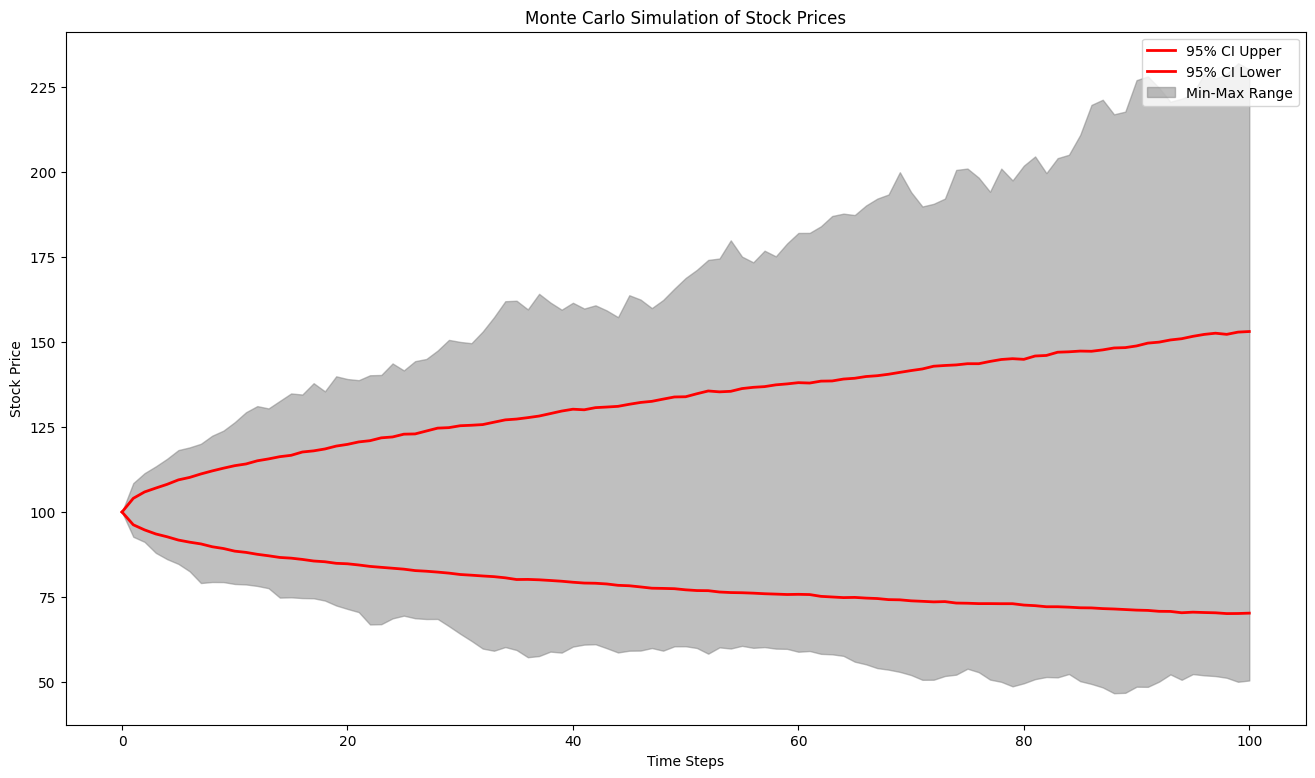

In [15]:
# Plot all paths
plt.figure(figsize=(16, 9))
#plt.plot(S.T, color='gray', alpha=0.1)
plt.plot(S_ci_upper, color='red', linewidth=2, label='95% CI Upper')
plt.plot(S_ci_lower, color='red', linewidth=2, label='95% CI Lower')

# Shade area between highest and lowest path
S_max = np.max(S, axis=0)
S_min = np.min(S, axis=0)
plt.fill_between(range(M+1), S_max, S_min, color='gray', alpha=0.5, label='Min-Max Range')

# Add Black-Scholes option price as a horizontal line
#plt.axhline(y=bs_option_price, color='blue', linestyle='--', linewidth=2, label='Black-Scholes Price')

# Add labels and legend
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Monte Carlo Simulation of Stock Prices')
plt.legend()
plt.show()

# Bootstraping de Series de Tiempos

In [16]:
# Block bootstrapping function
def block_bootstrap(data, block_size, num_samples):
    n = len(data)
    bootstrapped_series = []

    for _ in range(num_samples):
        indices = np.arange(n)
        block_start = np.random.choice(indices[:-block_size])
        bootstrap_sample = []

        for _ in range(int(n/block_size)):
            block = data[block_start:block_start+block_size]
            bootstrap_sample.extend(block)
            block_start = np.random.choice(indices[:-block_size])

        bootstrapped_series.append(bootstrap_sample[:n])

    return np.array(bootstrapped_series)

# Parameters
block_size = 10
num_samples = 1000

# Perform block bootstrapping
bootstrapped_data = block_bootstrap(prices, block_size, num_samples)
# Example of fitting a model (ARIMA) to the bootstrapped series
from statsmodels.tsa.arima.model import ARIMA

model_params = []

for series in bootstrapped_data:
    model = ARIMA(series, order=(1, 0, 1))
    fitted_model = model.fit()
    model_params.append(fitted_model.params)

print(fitted_model.summary())

# Convert to DataFrame for analysis
model_params_df = pd.DataFrame(model_params, columns=['const', 'ar.L1', 'ma.L1','sigma2'])

# Calculate statistics (e.g., mean and confidence intervals)
param_means = model_params_df.mean()
param_ci = model_params_df.quantile([0.025, 0.975])

print("Parameter Means:")
print(param_means)
print("\n95% Confidence Intervals:")
print(param_ci)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1650
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -14092.458
Date:                Wed, 17 Jul 2024   AIC                          28192.915
Time:                        20:02:10   BIC                          28214.550
Sample:                             0   HQIC                         28200.936
                               - 1650                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.3458     30.093      2.138      0.032       5.365     123.327
ar.L1         -0.0445      0.487     -0.091      0.927      -0.999       0.910
ma.L1          0.0083      0.486      0.017      0.9

# Aplicacion de Estrategias de Trading a Set x Bootstraped

In [17]:
sigma_hat = 1231.50
T_max = 100

results = apply_trading_logic(bootstrapped_data, construct_mesh(sigma_hat), T_max)

In [18]:
determine_optimal_rule(results)


pi             -14778.000000
pi_bar           1231.500000
sharpe_ratio        1.446423
Name: 0, dtype: float64

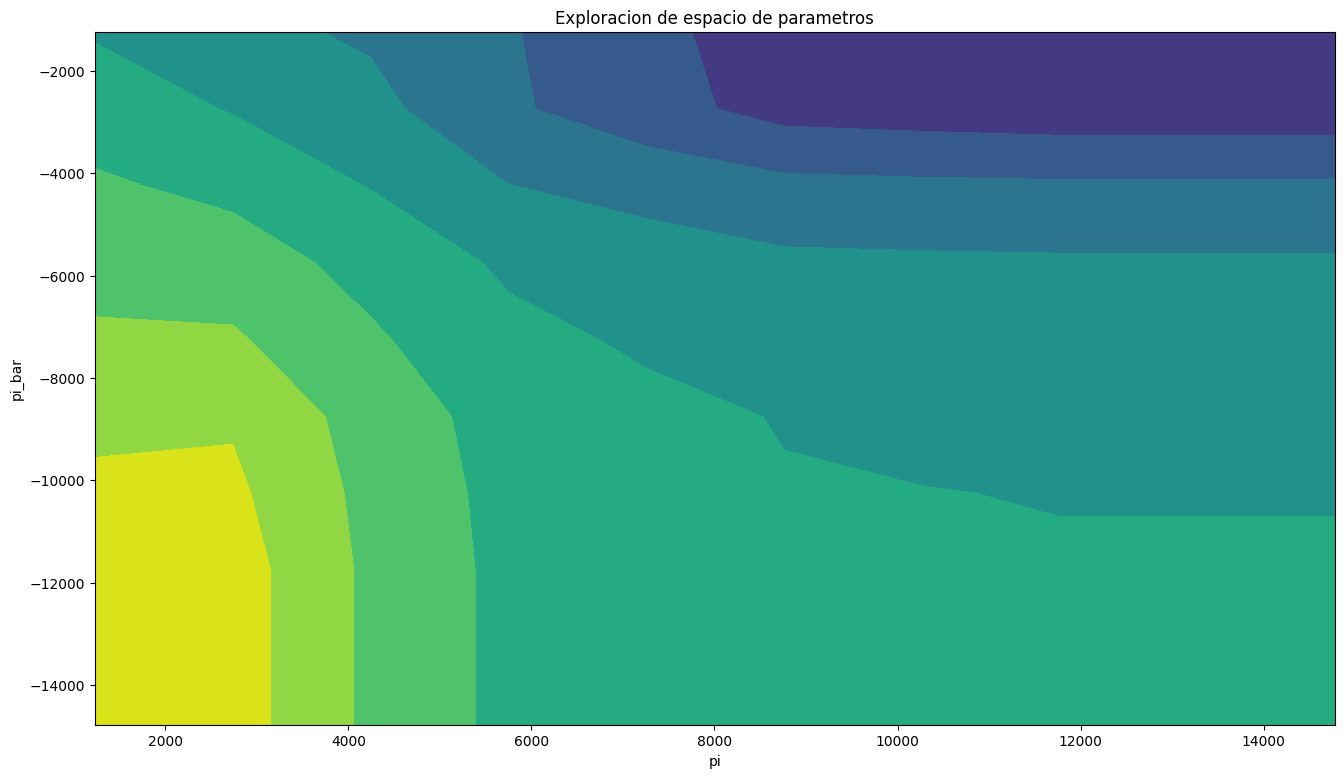

In [19]:
sorted_results = results.sort_values(by=['pi', 'pi_bar'])
pivot_table = sorted_results.pivot_table('sharpe_ratio','pi', 'pi_bar')

plt.figure(figsize=(16, 9))
contour = plt.contourf(pivot_table.columns, pivot_table.index, pivot_table, cmap='viridis')
plt.title('Exploracion de espacio de parametros')
plt.xlabel('pi')
plt.ylabel('pi_bar')
plt.show()